# Denoising Autoencoder

In [1]:
import logging

from fastai.basics import *
from fastai.callback.all import *
from fastai.torch_basics import *

from IPython.display import display

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import vaep
from vaep.io import datasplits
from vaep.models import ae
import vaep.models as models
import vaep.model
from vaep.analyzers import analyzers

# overwriting Recorder callback with custom plot_loss
from vaep.models import plot_loss
from fastai import learner

learner.Recorder.plot_loss = plot_loss


logger = vaep.logging.setup_logger(logging.getLogger('vaep'))
logger.info(
    "Experiment 03 - Analysis of latent spaces and performance comparisions")

figures = {}  # collection of ax or figures

vaep - INFO     Experiment 03 - Analysis of latent spaces and performance comparisions


In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

Papermill script parameters:

In [3]:
# files and folders
# Datasplit folder with data for experiment
folder_experiment: str = 'runs/example'
folder_data: str = ''  # specify data directory if needed
file_format: str = 'csv'  # file format of create splits, default pickle (pkl)
# Machine parsed metadata from rawfile workflow
fn_rawfile_metadata: str = 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv'
# training
epochs_max: int = 50  # Maximum number of epochs
# early_stopping:bool = True # Wheather to use early stopping or not
patience: int = 25  # Patience for early stopping
batch_size: int = 64  # Batch size for training (and evaluation)
cuda: bool = True  # Whether to use a GPU for training
# model
# Dimensionality of encoding dimension (latent space of model)
latent_dim: int = 25
# A underscore separated string of layers, '128_64' for the encoder, reverse will be use for decoder
hidden_layers: str = '512'

sample_idx_position: int = 0  # position of index which is sample ID
model: str = 'DAE'  # model name
model_key: str = 'DAE'  # potentially alternative key for model (grid search)
save_pred_real_na: bool = True  # Save all predictions for missing values
# metadata -> defaults for metadata extracted from machine data
meta_date_col: str = None  # date column in meta data
meta_cat_col: str = None  # category column in meta data

In [4]:
# Parameters
file_format = "csv"
latent_dim = 10
batch_size = 10
epochs_max = 5
hidden_layers = "512"
sample_idx_position = 0
cuda = False
save_pred_real_na = True
fn_rawfile_metadata = "data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv"
folder_experiment = "runs/example"
model_key = "DAE"


Some argument transformations

In [5]:
args = vaep.nb.get_params(args, globals=globals())
args

{'folder_experiment': 'runs/example',
 'folder_data': '',
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'epochs_max': 5,
 'patience': 25,
 'batch_size': 10,
 'cuda': False,
 'latent_dim': 10,
 'hidden_layers': '512',
 'sample_idx_position': 0,
 'model': 'DAE',
 'model_key': 'DAE',
 'save_pred_real_na': True,
 'meta_date_col': None,
 'meta_cat_col': None}

In [6]:
args = vaep.nb.args_from_dict(args)

if isinstance(args.hidden_layers, str):
    args.overwrite_entry("hidden_layers", [int(x)
                         for x in args.hidden_layers.split('_')])
else:
    raise ValueError(
        f"hidden_layers is of unknown type {type(args.hidden_layers)}")
args

{'batch_size': 10,
 'cuda': False,
 'data': Path('runs/example/data'),
 'epochs_max': 5,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/example'),
 'hidden_layers': [512],
 'latent_dim': 10,
 'meta_cat_col': None,
 'meta_date_col': None,
 'model': 'DAE',
 'model_key': 'DAE',
 'out_figures': Path('runs/example/figures'),
 'out_folder': Path('runs/example'),
 'out_metrics': Path('runs/example'),
 'out_models': Path('runs/example'),
 'out_preds': Path('runs/example/preds'),
 'patience': 25,
 'sample_idx_position': 0,
 'save_pred_real_na': True}

Some naming conventions

In [7]:
TEMPLATE_MODEL_PARAMS = 'model_params_{}.json'

## Load data in long format

In [8]:
data = datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/example/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/example/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/example/data/test_y.csv


data is loaded in long format

In [9]:
data.train_X.sample(5)

Sample ID                                       Gene Names
2020_02_12_05_06_Q-Exactive-HF-X-Orbitrap_6070  SPG21        28.563
                                                WBSCR16      28.269
2020_05_04_11_39_Q-Exactive-HF-X-Orbitrap_6070  YTHDF1       24.484
2020_05_12_18_10_Q-Exactive-HF-X-Orbitrap_6070  UBE4A        26.790
2020_05_20_12_33_Q-Exactive-HF-X-Orbitrap_6070  ATP1A1       31.157
Name: intensity, dtype: float64

Infer index names from long format

In [10]:
index_columns = list(data.train_X.index.names)
sample_id = index_columns.pop(args.sample_idx_position)
if len(index_columns) == 1:
    index_column = index_columns.pop()
    index_columns = None
    logger.info(f"{sample_id = }, single feature: {index_column = }")
else:
    logger.info(f"{sample_id = }, multiple features: {index_columns = }")

if not index_columns:
    index_columns = [sample_id, index_column]
else:
    raise NotImplementedError(
        "More than one feature: Needs to be implemented. see above logging output.")

vaep - INFO     sample_id = 'Sample ID', single feature: index_column = 'Gene Names'


load meta data for splits

In [11]:
if args.fn_rawfile_metadata:
    df_meta = pd.read_csv(args.fn_rawfile_metadata, index_col=0)
    display(df_meta.loc[data.train_X.index.levels[0]])
else:
    df_meta = None

,Version,Content Creation Date,Thermo Scientific instrument model,instrument attribute,instrument serial number,Software Version,firmware version,Number of MS1 spectra,Number of MS2 spectra,MS min charge,...,injection volume setting,Row,dilution factor,electron transfer dissociation,Comment,collision-induced dissociation,sample name,sample volume,Type,Number of MS3 spectra
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-18 14:35:26,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,336.000","114,830.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-19 19:48:33,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,312.000","117,156.000",2,...,2.500,2.000,1.000,NaN,NaN,NaN,NaN,NaN,QC,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-20 14:15:00,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,263.000","118,074.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,QC,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-27 12:29:44,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"11,862.000","115,333.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,QC,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-29 15:06:50,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"10,776.000","127,143.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-29 18:18:31,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"10,957.000","129,268.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,66,2020-01-02 17:38:26,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,243.000","120,125.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,66,2020-01-03 11:17:32,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"13,189.000","118,093.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,66,2020-01-03 16:58:20,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"11,172.000","126,830.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Produce some addional simulated samples

The validation simulated NA is used to by all models to evaluate training performance.

In [12]:
val_pred_simulated_na = data.val_y.to_frame(name='observed')
val_pred_simulated_na

,,observed
Sample ID,Gene Names,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,30.946
2020_02_28_12_27_Q-Exactive-HF-X-Orbitrap_6070,AAR2,27.248
2020_02_13_03_11_Q-Exactive-HF-X-Orbitrap_6070,ADAM10,29.310
2020_01_04_14_59_Q-Exactive-HF-X-Orbitrap_6070,NDUFAF4,24.352
2020_05_27_13_57_Q-Exactive-HF-X-Orbitrap_6070,EPN1,29.250
...,...,...
2020_03_01_23_00_Q-Exactive-HF-X-Orbitrap_6070,PRRC2B,24.294
2020_01_04_04_23_Q-Exactive-HF-X-Orbitrap_6070,ARGLU1,28.471
2020_02_18_18_55_Q-Exactive-HF-X-Orbitrap_6070,GBF1,29.470


In [13]:
test_pred_simulated_na = data.test_y.to_frame(name='observed')
test_pred_simulated_na.describe()

,observed
count,859.000
mean,28.270
std,2.543
min,22.254
25%,26.477
50%,28.068
75%,30.064
max,35.919


## Data in wide format

- Autoencoder need data in wide format

In [14]:
data.to_wide_format()
args.M = data.train_X.shape[-1]
data.train_X.head()

Gene Names,AAR2,ABCB6,ABHD11,ACAD9,ACTL6A,ACTN1,ACTR3,ADAM10,AHSA1,AK3,...,WBSCR16,WDR18,WDR33,WDR36,WDR61,WNK1,YBX1,YTHDF1,YWHAH,ZNF326
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,27.248,24.472,25.714,28.542,29.335,30.837,29.713,26.702,31.696,26.337,...,26.360,28.258,25.507,30.009,28.345,27.701,32.374,24.925,29.609,28.756
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,27.211,23.775,NaN,28.437,29.692,30.635,30.340,25.929,31.296,25.415,...,NaN,NaN,23.620,29.348,28.728,NaN,NaN,NaN,29.027,28.393
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,27.377,26.852,26.046,28.907,30.369,31.252,30.715,26.403,NaN,25.554,...,27.147,28.335,NaN,30.563,28.859,28.405,32.328,25.498,30.170,29.208
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,NaN,24.047,24.788,27.894,29.359,29.996,29.686,NaN,30.882,22.498,...,NaN,28.228,NaN,29.497,27.716,27.349,31.794,24.701,29.232,28.139
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,26.520,NaN,NaN,NaN,30.164,33.143,30.985,25.824,31.145,29.210,...,NaN,NaN,26.818,29.374,29.407,28.900,32.443,NaN,30.615,29.189


### Fill Validation data with potentially missing features

In [15]:
data.train_X

Gene Names,AAR2,ABCB6,ABHD11,ACAD9,ACTL6A,ACTN1,ACTR3,ADAM10,AHSA1,AK3,...,WBSCR16,WDR18,WDR33,WDR36,WDR61,WNK1,YBX1,YTHDF1,YWHAH,ZNF326
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,27.248,24.472,25.714,28.542,29.335,30.837,29.713,26.702,31.696,26.337,...,26.360,28.258,25.507,30.009,28.345,27.701,32.374,24.925,29.609,28.756
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,27.211,23.775,NaN,28.437,29.692,30.635,30.340,25.929,31.296,25.415,...,NaN,NaN,23.620,29.348,28.728,NaN,NaN,NaN,29.027,28.393
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,27.377,26.852,26.046,28.907,30.369,31.252,30.715,26.403,NaN,25.554,...,27.147,28.335,NaN,30.563,28.859,28.405,32.328,25.498,30.170,29.208
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,NaN,24.047,24.788,27.894,29.359,29.996,29.686,NaN,30.882,22.498,...,NaN,28.228,NaN,29.497,27.716,27.349,31.794,24.701,29.232,28.139
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,26.520,NaN,NaN,NaN,30.164,33.143,30.985,25.824,31.145,29.210,...,NaN,NaN,26.818,29.374,29.407,28.900,32.443,NaN,30.615,29.189
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,26.917,NaN,NaN,NaN,30.626,33.367,31.569,25.330,31.101,28.930,...,NaN,28.035,26.850,29.935,29.515,28.978,32.584,25.876,31.325,29.388
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,27.112,27.469,31.484,29.713,NaN,29.224,NaN,...,NaN,27.500,NaN,26.462,26.910,26.934,NaN,26.345,29.825,27.157
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,24.846,NaN,NaN,27.670,29.390,NaN,30.087,NaN,30.444,28.851,...,24.957,NaN,23.529,28.026,27.176,27.066,31.607,27.569,30.546,24.252
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,25.971,NaN,NaN,28.528,NaN,32.321,30.205,NaN,30.990,28.655,...,24.553,27.959,26.925,28.557,28.216,27.650,31.864,26.361,30.039,26.318


In [16]:
data.val_y  # potentially has less features

Gene Names,AAR2,ABCB6,ABHD11,ACAD9,ACTL6A,ACTN1,ADAM10,AHSA1,AK3,AKR1A1,...,WBP2,WBSCR16,WDR18,WDR33,WDR61,WNK1,YBX1,YTHDF1,YWHAH,ZNF326
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,26.618,32.214,NaN,NaN,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,26.873,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.303,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
data.val_y = pd.DataFrame(pd.NA, index=data.train_X.index,
                          columns=data.train_X.columns).fillna(data.val_y)
data.val_y

Gene Names,AAR2,ABCB6,ABHD11,ACAD9,ACTL6A,ACTN1,ACTR3,ADAM10,AHSA1,AK3,...,WBSCR16,WDR18,WDR33,WDR36,WDR61,WNK1,YBX1,YTHDF1,YWHAH,ZNF326
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,26.618,32.214,NaN,NaN,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,26.873,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Denoising Autoencoder

### Analysis: DataLoaders, Model, transform

In [18]:
default_pipeline = sklearn.pipeline.Pipeline(
    [
        ('normalize', StandardScaler()),
        ('impute', SimpleImputer(add_indicator=False))
    ])

analysis = ae.AutoEncoderAnalysis(
    train_df=data.train_X,
    val_df=data.val_y,
    model=ae.Autoencoder,
    transform=default_pipeline,
    decode=['normalize'],
    model_kwargs=dict(n_features=data.train_X.shape[-1],
                      n_neurons=args.hidden_layers,
                      last_decoder_activation=None,
                      dim_latent=args.latent_dim),
    bs=args.batch_size)
args.n_params = analysis.n_params_ae

if args.cuda:
    analysis.model = analysis.model.cuda()
analysis.model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=376, out_features=512, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=512, out_features=376, bias=True)
  )
)

### Training

In [19]:
analysis.learn = Learner(dls=analysis.dls,
                         model=analysis.model,
                         loss_func=MSELossFlat(reduction='sum'),
                         cbs=[EarlyStoppingCallback(patience=args.patience),
                              ae.ModelAdapter(p=0.2)]
                         )

analysis.learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, EarlyStoppingCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [ModelAdapter, CastToTensor]
         - after_pred     : [ModelAdapter]
         - after_loss     : [ModelAdapter]
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - a

Adding a `EarlyStoppingCallback` results in an error.  Potential fix in
[PR3509](https://github.com/fastai/fastai/pull/3509) is not yet in
current version. Try again later

In [20]:
# learn.summary()

SuggestedLRs(valley=0.0020892962347716093)

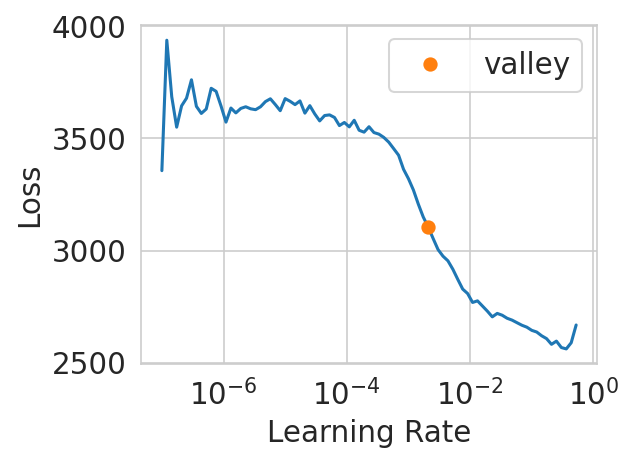

In [21]:
suggested_lr = analysis.learn.lr_find()
analysis.params['suggested_inital_lr'] = suggested_lr.valley
suggested_lr

dump model config

In [22]:
vaep.io.dump_json(analysis.params, args.out_models /
                  TEMPLATE_MODEL_PARAMS.format(args.model_key))

In [23]:
# papermill_description=train
analysis.learn.fit_one_cycle(args.epochs_max, lr_max=suggested_lr.valley)

epoch,train_loss,valid_loss,time
0,3466.798828,175.340912,00:00
1,2631.008545,148.420288,00:00
2,2191.371094,98.365143,00:00
3,1914.631836,70.123383,00:00
4,1746.797119,65.716194,00:00


Save number of actually trained epochs

In [24]:
args.epoch_trained = analysis.learn.epoch + 1
args.epoch_trained

5

#### Loss normalized by total number of measurements

vaep.plotting - INFO     Saved Figures to runs/example/figures/dae_training


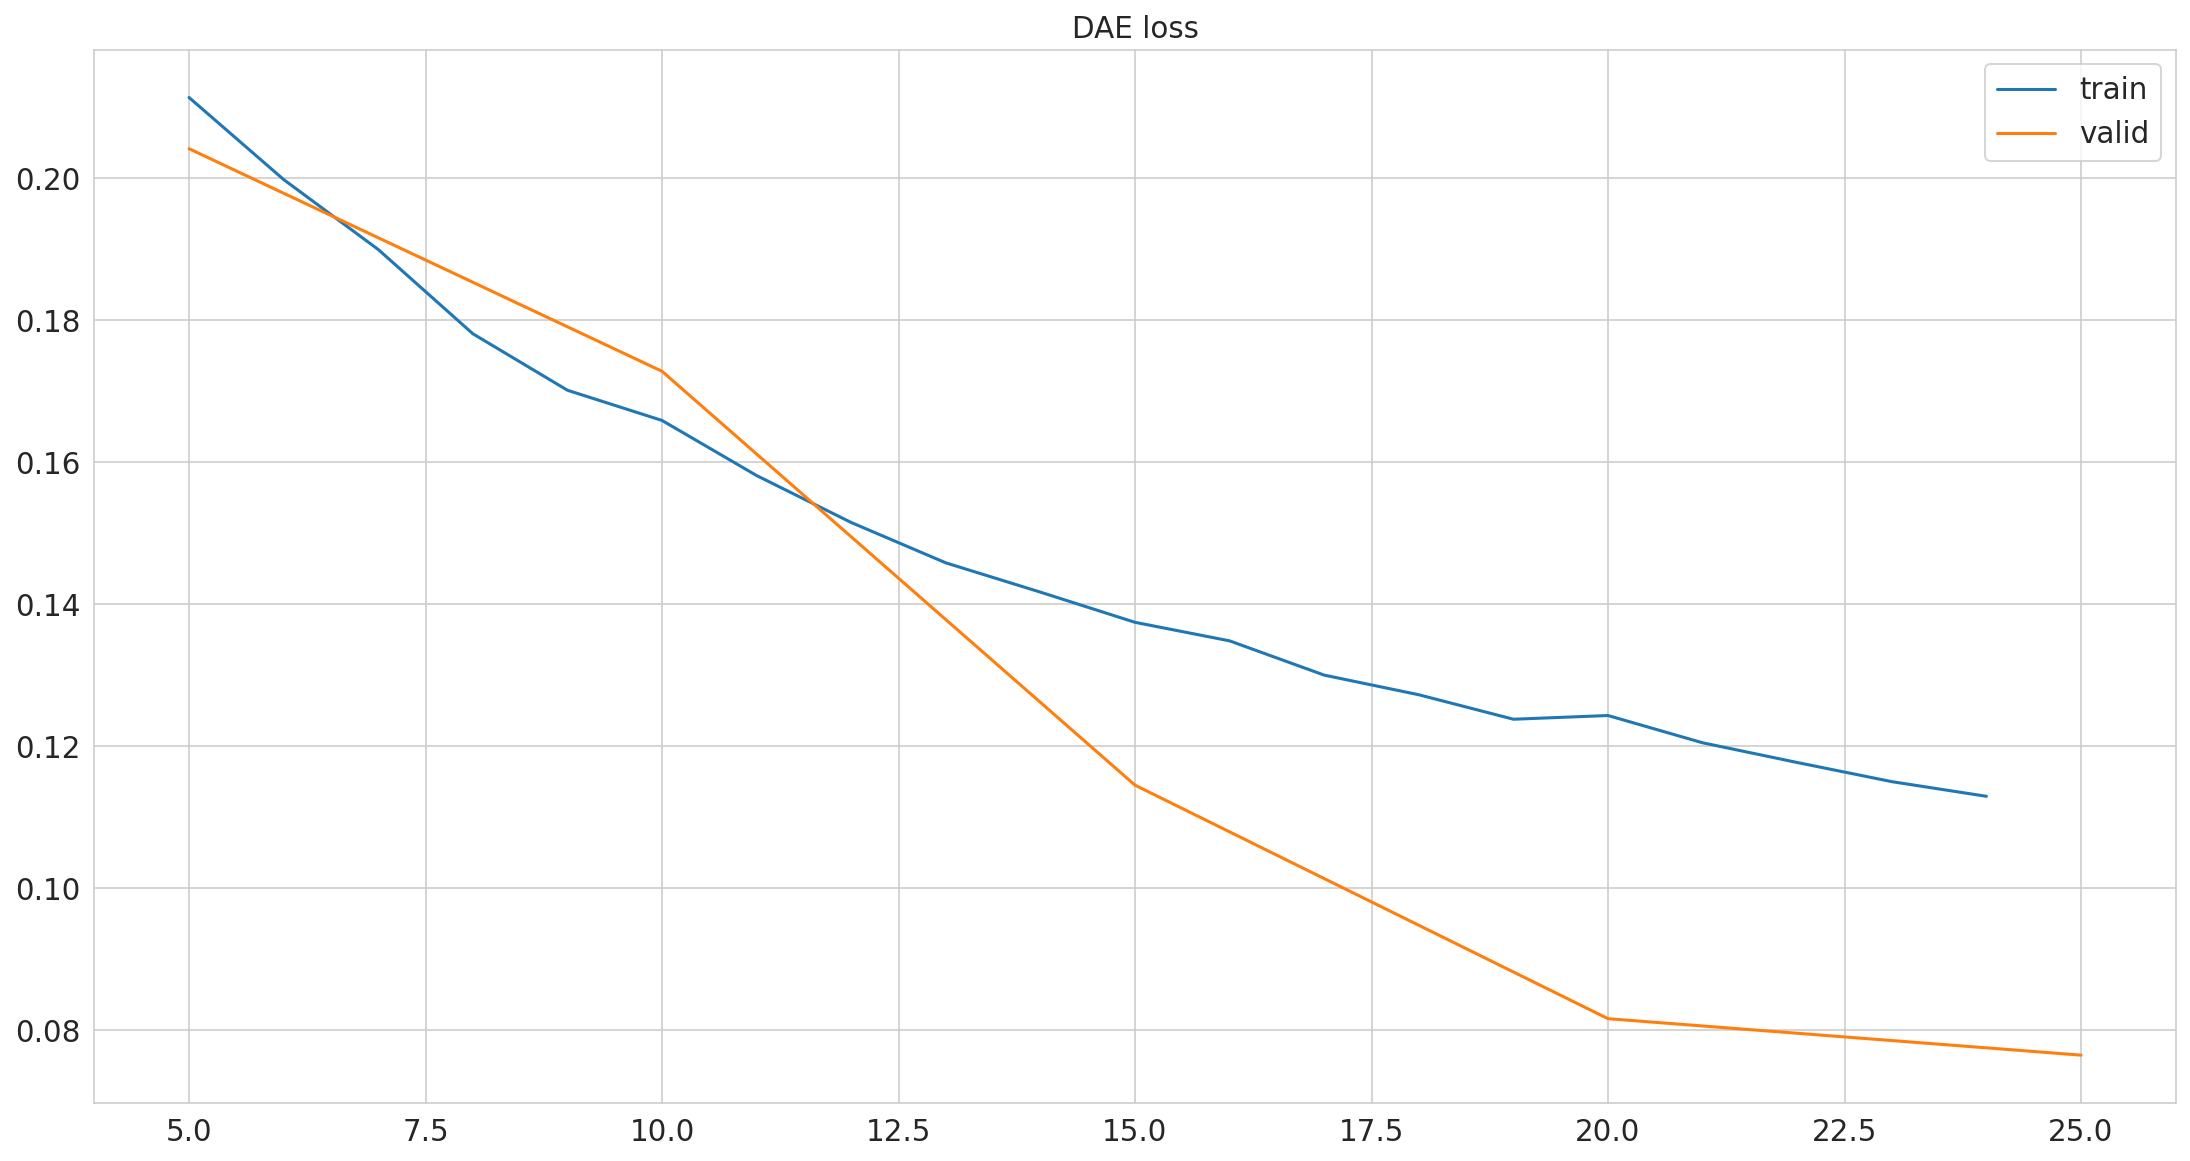

In [25]:
N_train_notna = data.train_X.notna().sum().sum()
N_val_notna = data.val_y.notna().sum().sum()
fig = models.plot_training_losses(analysis.learn, args.model_key,
                                  folder=args.out_figures,
                                  norm_factors=[N_train_notna, N_val_notna])

Why is the validation loss better then the training loss?
- during training input data is masked and needs to be reconstructed
- when evaluating the model, all input data is provided and only the artifically masked data is used for evaluation.

### Predictions

- data of training data set and validation dataset to create predictions is the same as training data.
- predictions include missing values (which are not further compared)

- [ ] double check ModelAdapter

create predictiona and select for validation data

In [26]:
analysis.model.eval()
pred, target = analysis.get_preds_from_df(df_wide=data.train_X)  # train_X
pred = pred.stack()
pred

Sample ID                                       Gene Names
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070  AAR2         27.003
                                                ABCB6        25.246
                                                ABHD11       25.456
                                                ACAD9        28.587
                                                ACTL6A       29.805
                                                              ...  
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070  WNK1         28.362
                                                YBX1         32.716
                                                YTHDF1       25.960
                                                YWHAH        30.005
                                                ZNF326       29.446
Length: 18800, dtype: float32

In [27]:
val_pred_simulated_na['DAE'] = pred  # model_key ?
val_pred_simulated_na

,,observed,DAE
Sample ID,Gene Names,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,30.946,31.086
2020_02_28_12_27_Q-Exactive-HF-X-Orbitrap_6070,AAR2,27.248,26.780
2020_02_13_03_11_Q-Exactive-HF-X-Orbitrap_6070,ADAM10,29.310,27.800
2020_01_04_14_59_Q-Exactive-HF-X-Orbitrap_6070,NDUFAF4,24.352,25.661
2020_05_27_13_57_Q-Exactive-HF-X-Orbitrap_6070,EPN1,29.250,29.728
...,...,...,...
2020_03_01_23_00_Q-Exactive-HF-X-Orbitrap_6070,PRRC2B,24.294,24.179
2020_01_04_04_23_Q-Exactive-HF-X-Orbitrap_6070,ARGLU1,28.471,28.859
2020_02_18_18_55_Q-Exactive-HF-X-Orbitrap_6070,GBF1,29.470,29.513


In [28]:
test_pred_simulated_na['DAE'] = pred  # model_key?
test_pred_simulated_na

observed    DAE
Sample ID                                      Gene Names                 
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070 ARAF          23.248 26.222
                                               CENPH         25.045 24.754
                                               CLPP          27.745 27.772
                                               GNAI1         24.335 26.053
                                               KIAA1143      26.901 26.821
...                                                             ...    ...
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070 NUDT9         27.658 27.219
                                               PTPN1         29.024 29.055
                                               RDH13         28.720 28.357
                                               RNASEH2C      26.742 26.373
                                               SH3BGRL3      29.162 29.198

[859 rows x 2 columns]

save missing values predictions

In [29]:
if args.save_pred_real_na:
    pred_real_na = ae.get_missing_values(df_train_wide=data.train_X,
                                         val_idx=val_pred_simulated_na.index,
                                         test_idx=test_pred_simulated_na.index,
                                         pred=pred)
    display(pred_real_na)
    pred_real_na.to_csv(args.out_preds / f"pred_real_na_{args.model_key}.csv")

Sample ID                                       Gene Names 
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070  ARMCX3        23.887
                                                BDH2          24.415
                                                CCBL2         26.779
                                                COMMD5        25.360
                                                DNAJC10       25.358
                                                               ...  
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070  TMEM261       25.921
                                                TRMT2A        26.508
                                                TSNAX;DISC1   27.246
                                                UTRN          26.732
                                                VPS11         26.425
Name: intensity, Length: 1616, dtype: float32

### Plots

- validation data

In [30]:
analysis.model.cpu()
df_latent = vaep.model.get_latent_space(analysis.model.encoder,
                                        dl=analysis.dls.valid,
                                        dl_index=analysis.dls.valid.data.index)
df_latent

,latent dimension 1,latent dimension 2,latent dimension 3,latent dimension 4,latent dimension 5,latent dimension 6,latent dimension 7,latent dimension 8,latent dimension 9,latent dimension 10
Sample ID,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,-0.388,-0.831,-0.112,1.423,-0.229,-0.389,0.525,-0.340,-0.448,-1.069
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,-0.439,-1.173,0.278,1.082,-0.592,-1.277,1.558,-1.517,-1.161,-1.250
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,-0.758,-1.259,-0.920,1.224,0.253,0.009,-0.038,0.347,-0.211,-1.333
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,-0.239,-0.979,0.774,0.799,-0.702,-1.910,1.753,-2.040,-1.347,-1.250
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,1.248,2.090,-0.339,-2.310,-0.442,0.104,-2.523,1.164,1.473,2.707
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,1.560,1.846,-0.715,-2.038,-0.649,0.609,-3.342,1.522,2.012,2.890
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,1.536,0.891,4.142,-1.963,-1.409,-3.317,0.879,-4.459,-1.969,1.579
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,1.047,1.405,2.406,-2.941,-0.559,-0.675,-0.633,-2.062,-0.617,1.521
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,1.354,2.286,0.392,-2.687,-0.781,-0.497,-1.717,0.298,0.642,2.384


In [31]:
# ! calculate embeddings only if meta data is available? Optional argument to save embeddings?
ana_latent = analyzers.LatentAnalysis(df_latent,
                                      df_meta,
                                      args.model_key,
                                      folder=args.out_figures)
if args.meta_date_col and df_meta is not None:
    figures[f'latent_{args.model_key}_by_date'], ax = ana_latent.plot_by_date(
        args.meta_date_col)

In [32]:
if args.meta_cat_col and df_meta is not None:
    figures[f'latent_{args.model_key}_by_{"_".join(args.meta_cat_col.split())}'], ax = ana_latent.plot_by_category(
        args.meta_cat_col)

## Comparisons

Simulated NAs : Artificially created NAs. Some data was sampled and set
explicitly to misssing before it was fed to the model for
reconstruction.

### Validation data

- all measured (identified, observed) peptides in validation data

In [33]:
# papermill_description=metrics
d_metrics = models.Metrics()

The simulated NA for the validation step are real test data (not used for training nor early stopping)

In [34]:
added_metrics = d_metrics.add_metrics(val_pred_simulated_na, 'valid_simulated_na')
added_metrics

Selected as truth to compare to: observed


{'DAE': {'MSE': 0.6631208222080108,
  'MAE': 0.5473140900248381,
  'N': 859,
  'prop': 1.0}}

### Test Datasplit

In [35]:
added_metrics = d_metrics.add_metrics(test_pred_simulated_na, 'test_simulated_na')
added_metrics

Selected as truth to compare to: observed


{'DAE': {'MSE': 0.5089888324685997,
  'MAE': 0.5070540830738314,
  'N': 859,
  'prop': 1.0}}

Save all metrics as json

In [36]:
vaep.io.dump_json(d_metrics.metrics, args.out_metrics /
                  f'metrics_{args.model_key}.json')
d_metrics

{ 'test_simulated_na': { 'DAE': { 'MAE': 0.5070540830738314,
                                  'MSE': 0.5089888324685997,
                                  'N': 859,
                                  'prop': 1.0}},
  'valid_simulated_na': { 'DAE': { 'MAE': 0.5473140900248381,
                                   'MSE': 0.6631208222080108,
                                   'N': 859,
                                   'prop': 1.0}}}

In [37]:
metrics_df = models.get_df_from_nested_dict(d_metrics.metrics,
                                            column_levels=['model', 'metric_name']).T
metrics_df

subset             valid_simulated_na  test_simulated_na
model metric_name                                       
DAE   MSE                       0.663              0.509
      MAE                       0.547              0.507
      N                       859.000            859.000
      prop                      1.000              1.000

## Save predictions

In [38]:
# save simulated missing values for both splits
val_pred_simulated_na.to_csv(args.out_preds / f"pred_val_{args.model_key}.csv")
test_pred_simulated_na.to_csv(args.out_preds / f"pred_test_{args.model_key}.csv")

## Config

In [39]:
figures  # switch to fnames?

{}

In [40]:
args.dump(fname=args.out_models / f"model_config_{args.model_key}.yaml")
args

{'M': 376,
 'batch_size': 10,
 'cuda': False,
 'data': Path('runs/example/data'),
 'epoch_trained': 5,
 'epochs_max': 5,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/example'),
 'hidden_layers': [512],
 'latent_dim': 10,
 'meta_cat_col': None,
 'meta_date_col': None,
 'model': 'DAE',
 'model_key': 'DAE',
 'n_params': 398722,
 'out_figures': Path('runs/example/figures'),
 'out_folder': Path('runs/example'),
 'out_metrics': Path('runs/example'),
 'out_models': Path('runs/example'),
 'out_preds': Path('runs/example/preds'),
 'patience': 25,
 'sample_idx_position': 0,
 'save_pred_real_na': True}